In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

In [20]:
#nbx --fname="src/cuda_raycaster.jl"
using CUDA
using BenchmarkTools
using Colors, Plots
col = palette(:default);

# CUDA 2D Raycaster - Line Map

In [3]:
# Todo: collect these helper somewhere
# Done: moved them to MyUtils.jl
"""Stacks vectors on top each other (along dim 1)"""
function stack(xs::Vector{Vector{T}}) where T <: Number; return reduce(vcat,transpose.(xs)) end
"""Stacks vectors horizontally (along dim 2)"""
function hstack(xs::Vector{Vector{T}}) where T <: Number; return reduce(hcat,xs) end
 
polar_inv(zs::Vector{Float64}, as::Vector{Float64}) = [[z*cos(a);z*sin(a)] for (z,a) in zip(zs,as)];

In [4]:
#nbx
"""
    griddims = cuda_grid(datadims::Tuple{Vararg{Int}}, 
                         blockdims::Tuple{Vararg{Int}})

Given data dimensions `datadims` and number of threads 
in each dimension `blockdims` returns the respective 
grid dimensions `griddims` such that

    griddims[i] = ceil(Int, datadims[i]/blockdims[i])

"""
function cuda_grid(datadims::Tuple{Vararg{Int}}, blockdims::Tuple{Vararg{Int}})
    griddims = ceil.(Int, datadims./blockdims)
    return griddims
end

cuda_grid

## Time it - putting stuff on the GPU

In [5]:
function bench_cuarray(x,y,z)
    x_  = CuArray(x)
    y_  = CuArray(y)
    z_  = CuArray(z)
end

n = 1_000
m = 1_000
x = rand(n,2)
y = rand(m,4)
z = rand(n,4)

bs = []
for e=1:6
    n = 10^e
    x = rand(n,2)
    y = rand(n,2);
    z = rand(n,2);
    b = @benchmark bench_cuarray($x,$y,$z) samples=3 evals=3;
    push!(bs, b)
end

mean.(bs)

6-element Vector{BenchmarkTools.TrialEstimate}:
 55.714 μs
 34.719 μs
 45.291 μs
 127.932 μs
 765.845 μs
 5.893 ms

```julia
10   >> 33.175 μs
10^2 >> 32.889 μs
10^3 >> 36.669 μs
10^4 >> 134.479 μs
10^5 >> 753.159 μs
10^6 >> 6.102 ms
```

## CPU Baseline

Compute the intersection of two lines by solving: $x + s \cdot dx = y + t \cdot dy$.

Implementation from my `Geometry.jl` package:

```julia
function line_intersect(x, x′, y, y′)
    dx = x′ - x
    dy = y′ - y
    if det([-dx dy]) == 0
        return [Inf;Inf]
    end
    s, t = inv([-dx dy])*(x - y)
    return s,t
end;
```

In [6]:
function cast_cpu!(X, A, p, Z)    
    
    for i = 1:size(X,1), j = 1:size(A,1)
        
        x1, x2 = X[i,1], X[i,2]
        y1, y2 = p[1], p[2]
        v1 = (x1 - y1)
        v2 = (x2 - y2)
        
        dx1, dx2 = X[i,3] - X[i,1], X[i,4] - X[i,2]
        dy1, dy2 = cos(A[j]+p[3]), sin(A[j] + p[3])
        
        a, b = -dx1, dy1
        c, d = -dx2, dy2
        det = a*d - c*b
        if det != 0
            s = 1/det*(  d*v1 - b*v2)
            t = 1/det*(- c*v1 + a*v2)
            if t >= 0 && 0 <= s && s <= 1
                @inbounds Z[j] = min(t,Z[j])
            end
        end
    end
    return
end

function bench_cast_cpu!(X,A,p,Y)
    cast_cpu!(X,A,p,Y)
end

bench_cast_cpu! (generic function with 1 method)

## CUDA kernel

In [21]:
#nbx
"""
    cast!(X, A, p, Z)

Given a segment matrix `X`, angles `A`, a pose `p` encoded as a 3-tuple,
and a depth vector that is to be filled.

Example:
```
n = size(X,1)
m = size(A,1)

blockdims = (16, 16)
griddims = cuda_grid((n,m), blockdims)
CUDA.@sync begin
    @cuda threads=blockdims blocks=griddims cast!(X, A, p, Z)
end
```
"""
function cast!(X, A, p, Z)
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    
    for i = ix:sx:size(X,1), j = iy:sy:size(A,1)
        
        x1, x2 = X[i,1], X[i,2]
        y1, y2 = p[1], p[2]
        v1 = (x1 - y1)
        v2 = (x2 - y2)
        
        dx1, dx2 = X[i,3] - X[i,1], X[i,4] - X[i,2]
        dy1, dy2 = cos(A[j]+p[3]), sin(A[j] + p[3])
        
        a, b = -dx1, dy1
        c, d = -dx2, dy2
        det = a*d - c*b
        if det != 0
            s = 1/det*(  d*v1 - b*v2)
            t = 1/det*(- c*v1 + a*v2)
            if t >= 0 && 0 <= s && s <= 1
                @inbounds Z[j] = min(t,Z[j])
            end
        end
        
    end
    return
end

function bench_cast!(X, A, p, Z)
    n = size(X,1)
    m = size(A,1)

    blockdims = (16, 16)
    griddims = cuda_grid((n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims cast!(X, A, p, Z)
    end
end

bench_cast! (generic function with 1 method)

In [8]:
n     = 1_000
num_a = 361

x = (2*rand(n,4).-1.0)
a = collect(range(0, 2π, num_a))
z = ones(size(a,1))
p = zeros(3)
    
println(size(x), size(a))

n = size(x,1)
m = size(a,1)

x_ = CuArray(x)
a_ = CuArray(a)
z_ = CuArray(z)
p_ = CuArray(p)
    
blockdims = (16,16)
griddims = cuda_grid((n,m), blockdims)
@cuda threads=blockdims blocks=griddims cast!(x_,a_,p_,z_)
@btime bench_cast!($x_,$a_,$p_,$z_) samples=3 evals=3;
@btime bench_cast_cpu!($x,$a,$p,$z) samples=3 evals=3;

(1000, 4)(361,)
  46.272 μs (24 allocations: 1.41 KiB)
  10.406 ms (0 allocations: 0 bytes)


```julia
(1000, 4)(361,)
  46.205 μs (24 allocations: 1.41 KiB)
  10.439 ms (0 allocations: 0 bytes)
```

## Example

In [9]:
using JSON
using LinearAlgebra: norm

fname = "./data/data_3.json"
d = JSON.parsefile(fname)

_segs = Array{Float64}.(d["env"]["segs"]);
_xs   = Array{Float64}.(d["motion"]["x"]);
_hds  = Array{Float64}(d["motion"]["hd"]);

_a    = Array{Float64}(d["sensor"]["a"]);
_zs   = Array{Float64}.(d["sensor"]["z"]);
_zmax = d["sensor"]["zmax"]

20

In [10]:
t = 20
segs = stack(_segs)
a    = _a[1:end]
p    = [_xs[t];_hds[t]]
z    = ones(length(a))*_zmax;

In [11]:
println(size(segs), size(a), size(z), size(p))
println()

@btime begin
segs_ = CuArray(segs)
a_    = CuArray(a)
z_    = CuArray(z)
p_    = CuArray(p)
end samples=1 evals=1;

(427, 4)(361,)(361,)(3,)

  103.985 μs (16 allocations: 640 bytes)


In [12]:
segs_ = CuArray(segs)
a_    = CuArray(a)
z_    = CuArray(z)
p_    = CuArray(p)

n = size(segs,1)
m = size(a,1)

blockdims = (64,4)
griddims = cuda_grid((n,m), blockdims)

println("Data dim: |env| = $(size(segs)), |a| = $(size(a))")
println("Threads per Block: $(prod(blockdims))")
println("Block dim: $(blockdims)")
println("Grid  dim: $(griddims)")
println()

@cuda threads=blockdims blocks=griddims cast!(segs_,a_,p_,z_)

@btime bench_cast!($segs_,$a_,$p_,$z_) samples=5 evals=5;

Data dim: |env| = (427, 4), |a| = (361,)
Threads per Block: 256
Block dim: (64, 4)
Grid  dim: (7, 91)

  25.025 μs (24 allocations: 1.41 KiB)


```julia
20.652 μs (24 allocations: 1.41 KiB)
```

In [13]:
@btime cast_cpu!($segs, $a, $p, $z) samples=5 evals=5;

  4.276 ms (0 allocations: 0 bytes)


```julia
526.393 μs (0 allocations: 0 bytes)
```

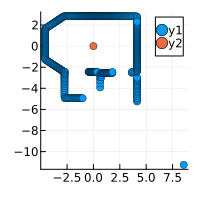

In [14]:
z  = Array(z_)
ys = stack(polar_inv(z, a .+ p[3]))
# ---------------------------------------
plot(size=(200,200), aspect_ratio=:equal)
scatter!(ys[:,1], ys[:,2])
scatter!([0],[0])

## Gen - sensor model

In [15]:
using Gen

In [16]:
t = 20

segs = stack(_segs)
a    = _a[1:end]
p    = [_xs[t];_hds[t]]
z    = ones(length(a))*_zmax;

segs_ = CuArray(segs)
a_    = CuArray(a)
z_    = CuArray(z)
p_    = CuArray(p);

size(segs), size(a)

((427, 4), (361,))

In [17]:
@gen function sensor_model(x, hd, std)
        K = length(a_)
    
        z_ = CuArray(ones(K)*_zmax)
        p_ = CuArray([x;hd])
    
        n = length(segs_)
        m = length(a_)
        blockdims = (32,8)
        griddims = cuda_grid((n,m), blockdims)
        CUDA.@sync begin
            @cuda threads=blockdims blocks=griddims cast!(segs_,a_,p_,z_)
        end
        z ~ broadcasted_normal(Array(z_), std*ones(K))
end;

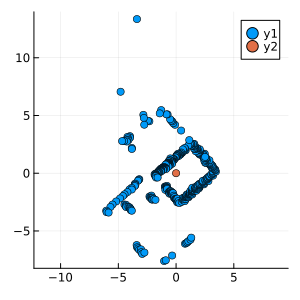

In [18]:
t   = 5
std = 0.1

z  = sensor_model(_xs[t],_hds[t], std);
ys = stack(polar_inv(z, a .+ p[3]))
# ---------------------------------------
plot(size=(300,300), aspect_ratio=:equal)
scatter!(ys[:,1], ys[:,2])
scatter!([0],[0])

In [19]:
args = (_xs[t],_hds[t], std);
ch   = choicemap(:z => _zs[t]);
@btime simulate($sensor_model, $args )     samples=1 evals=1;
@btime generate($sensor_model, $args, $ch) samples=1 evals=1;

  88.963 μs (81 allocations: 40.45 KiB)
  88.399 μs (83 allocations: 34.56 KiB)


```julia
88.985 μs (81 allocations: 40.45 KiB)
87.488 μs (83 allocations: 34.56 KiB)
```